In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append("..") # Adds higher directory to python modules path.


import seaborn as sns
import matplotlib

plt.rcParams["figure.figsize"] = (20,8)

sns.set_theme()

font = {'family' : 'DejaVu Sans', 'size'   : 25}

matplotlib.rc('font', **font)

In [2]:
from StocksDataWrapper import *
from DataHelper import *
from Plots import *
from DL_utils import *

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


### Prepare data

In [4]:
DATA_PATH = '../data/'
FILE_SUFFIX='.txt'

quotation = 'IBM'
price_column = 'Close'
project_label='LinearNN2Classes'

predict_n = 5

In [5]:
data_wrapper = StocksDataWrapper.read_from(file_path=f"{DATA_PATH}{quotation}{FILE_SUFFIX}", thresh_diff=None,
                                           compute_features=True, predict_n=predict_n, normalize=True)

data_wrapper.head()

0          7.393333
1          7.440000
2          7.346667
3          7.353333
4          7.360000
            ...    
14826    124.690002
14827    124.820000
14828    123.800003
14829    124.339996
14830    125.879997
Name: Close, Length: 14831, dtype: float64


,Date,Open,High,Low,Close,Adjusted,Volume,LowLen,RSI(14),GAP,...,SMA(10),SMA(20),EMA(14),EMA_Diff,SMA(20) - SMA(10),Difference,PercentageDiff,Tendency,NextPrice,Next
0,1962-03-21,-0.969143,-0.970953,-0.968426,-0.969142,-0.989960,-0.992440,-0.994949,0.190050,-1.000000,...,-0.970994,-0.972890,-0.972642,0.226349,-0.211123,0.150097,0.287239,higher,-0.969897,lower
1,1962-03-22,-0.969333,-0.971331,-0.968933,-0.969897,-0.990206,-0.993088,-1.000000,-0.086189,-0.996718,...,-0.971052,-0.972827,-0.972726,0.222777,-0.210005,0.144423,0.222916,lower,-0.969645,higher
2,1962-03-23,-0.969774,-0.971457,-0.968870,-0.969645,-0.990124,-0.994600,-1.000000,0.010611,-0.999180,...,-0.971128,-0.972763,-0.972764,0.224308,-0.208694,0.151406,0.302294,higher,-0.969677,lower
3,1962-03-26,-0.969585,-0.971331,-0.968806,-0.969677,-0.990134,-0.996112,-0.997475,-0.000086,-1.000000,...,-0.971202,-0.972688,-0.972801,0.224334,-0.207308,0.149442,0.279795,lower,-0.970968,lower
4,1962-03-27,-0.969774,-0.971772,-0.970074,-0.970968,-0.990554,-0.989848,-0.998317,-0.334177,-0.997949,...,-0.971400,-0.972684,-0.973008,0.218572,-0.205430,0.140714,0.180072,lower,-0.970590,higher


In [6]:
data_wrapper['Next'].value_counts()

lower     7555
higher    7242
Name: Next, dtype: int64

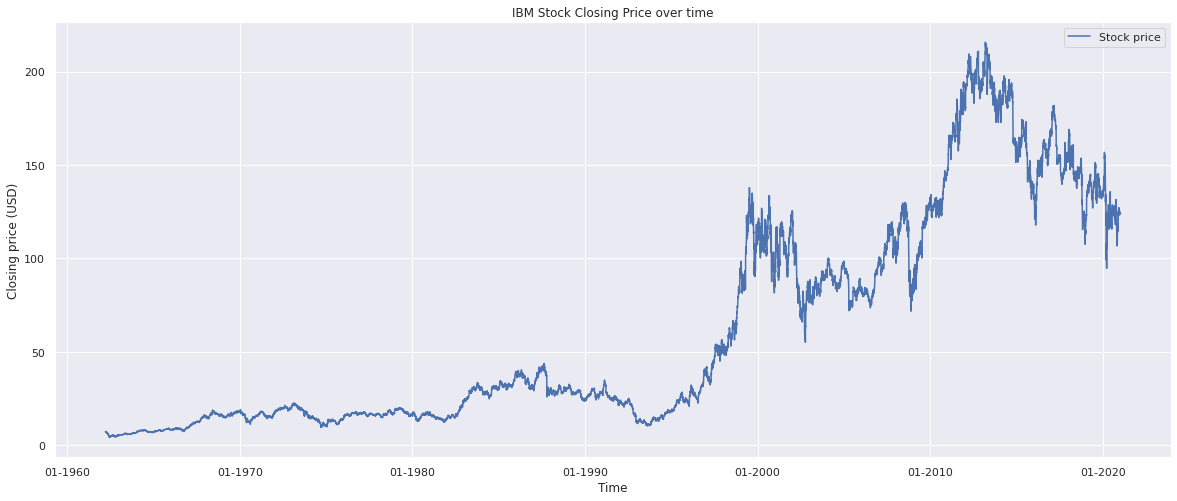

In [7]:
prices = data_wrapper.get_unscaled_data()['Close']
plot_prices(price_series=prices, date_series=data_wrapper['Date'], quotation_name=quotation)
plt.show()

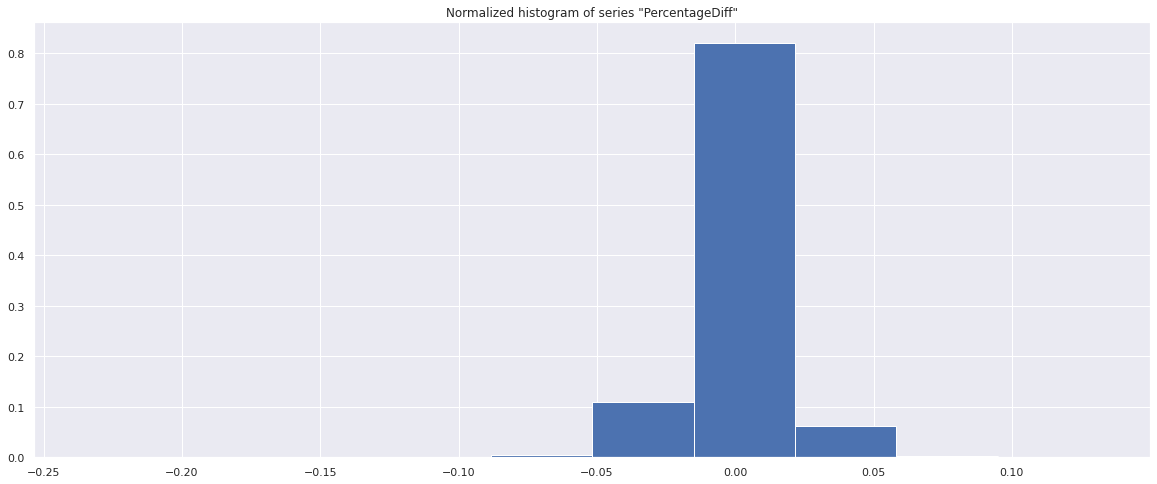

In [8]:
ax = plot_normalized_histogram(data_wrapper.get_unscaled_data()['PercentageDiff'])

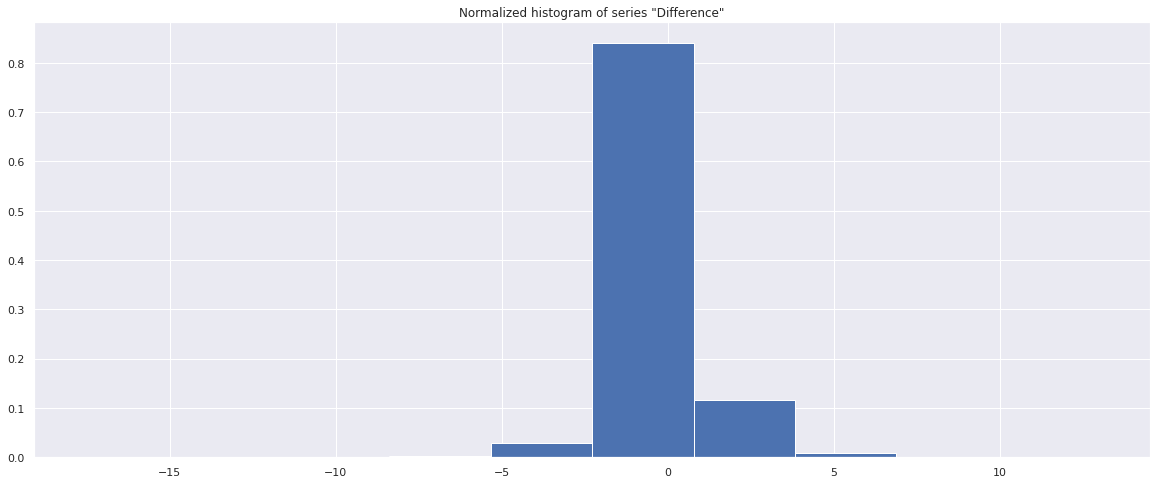

In [9]:
ax = plot_normalized_histogram(data_wrapper.get_unscaled_data()['Difference'])

In [10]:
df = data_wrapper.df
feature_names = data_wrapper.feature_names

In [11]:
from torch.utils.data import Dataset
from TorchDatasets import StocksDataset

y_column = 'Next'
data_columns = ['Close', 'Volume'] + feature_names
data_columns = ['Close', 'Volume', 'MACD_diff', 'RSI(14)', 'PercentageDiff', 'LowLen', 'RSI_diff']
data_columns += [y_column]


dataset = df.copy()
dataset = dataset.loc[:, data_columns]

for col in dataset.columns:
    dataset[col] = dataset[col].replace({'higher':2, 'stay':1, 'lower':0})
    

    
X = dataset.loc[:, dataset.columns != y_column]
y = dataset[y_column]

X.head()

,Close,Volume,MACD_diff,RSI(14),PercentageDiff,LowLen,RSI_diff
0,-0.969142,-0.992440,0.092956,0.190050,0.287239,-0.994949,-0.033275
1,-0.969897,-0.993088,0.090990,-0.086189,0.222916,-1.000000,-0.460281
2,-0.969645,-0.994600,0.090242,0.010611,0.302294,-1.000000,0.071843
3,-0.969677,-0.996112,0.089731,-0.000086,0.279795,-0.997475,-0.081496
4,-0.970968,-0.989848,0.086874,-0.334177,0.180072,-0.998317,-0.542804


In [12]:
y.value_counts()

0    7555
2    7242
Name: Next, dtype: int64

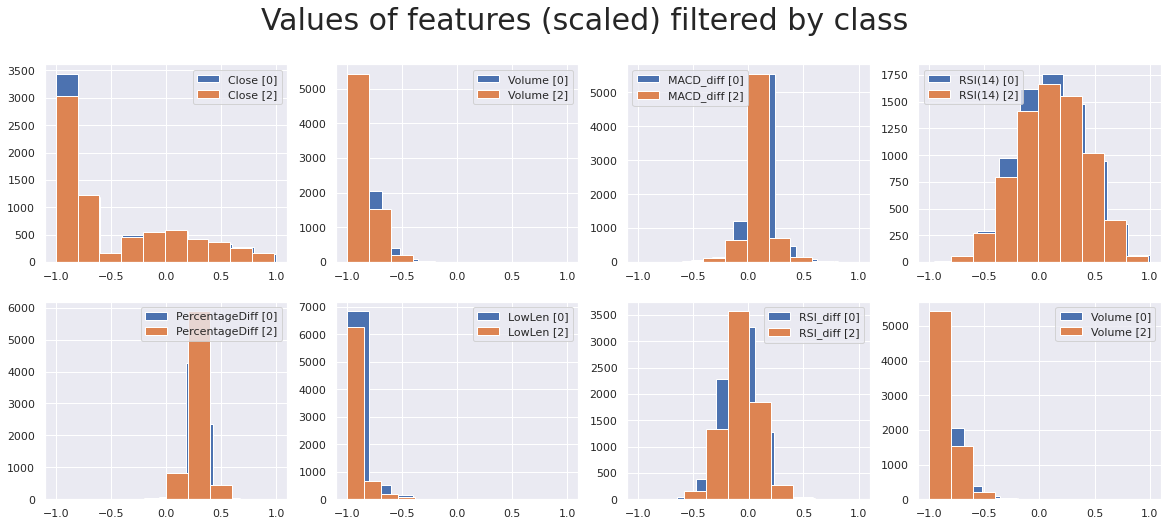

In [13]:
N_COLS = 4
plot_feature_names = data_columns.copy()

if 'Next' in plot_feature_names:
    plot_feature_names.remove('Next')
if 'Volume' in dataset.columns.values:
    plot_feature_names.append('Volume')
plot_filtered_class_features(dataset, n_cols=N_COLS, feature_names=plot_feature_names, class_column='Next')

plt.show()

In [14]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

train_dataset = StocksDataset(X_train,y_train)
test_dataset = StocksDataset(X_test, y_test)

print(f"Train size : {len(train_dataset)}, test_size : {len(test_dataset)}")

Train size : 10357, test_size : 4440


In [15]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

### Model

In [16]:
import torch.nn as nn
from DL_utils import *

class LinearModel(nn.Module):
    
    def __init__(self, input_dim, output_dim, **kwargs):
        super(LinearModel, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(8),
            nn.Linear(8, 16),
            nn.LeakyReLU(0.1),
            nn.Linear(16, 16),
            nn.LeakyReLU(0.1),
            #nn.Dropout(),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.1),
            nn.Linear(8, output_dim),
            #nn.Softmax(1),
        )
        
        
    def forward(self, x):
        out = self.classifier(x)
        return out

lr = 0.005
model, optimizer, loss_fn = create_model(LinearModel, device=device, input_dim = len(X.columns), output_dim=3, 
                                            loss_fn=nn.CrossEntropyLoss, optimizer=torch.optim.Adam, lr=lr,
                                            use_wandb=False, project_label=project_label)

train(model, train_dataloader, n_epochs=50, optimizer=optimizer, loss_fn=loss_fn, acc_func=cross_entropy_acc, device=device, use_wandb=False, epoch_log=10)

  0%|                                                                                                                   | 0/50 [00:03<?, ?it/s]


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target' in call to _thnn_nll_loss_forward

In [ ]:
predictions, labels = predict(model, test_dataloader, device)

In [ ]:
metrics_dict = compute_metrics(model, test_dataloader, device)

print(metrics_dict)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score

print(f"Test accuracy : {100 * metrics_dict['accuracy']:.2f}%")

class_labels = ['lower', 'higher']

ax = plot_heatmap(labels, predictions, class_labels, normalize='all')

In [ ]:
ax = plot_roc_auc_curve(labels, predictions)